In [1]:
import numpy as np
import pymc3 as pm
import arviz as az
print("Running on PyMC3 v{}".format(pm.__version__))
print('Running on ArviZ v{}'.format(az.__version__))

from libLN import LogNormalField
%run config_10.py

from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import defaultdict
import corner

Running on PyMC3 v3.9.3
Running on ArviZ v0.11.0
Figures saved at figures/Output20_05_10_80_80_500_80_1_123456
Simulations saved at data/Sims20_05_10_80_80_500_80_1_123456


In [2]:
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

In [3]:
# Set the seed for reproducibility
f=0
np.random.seed(seed+f)

# Load observed field

In [4]:
# Load data vector
LN=LogNormalField(Lside,rmax,nbin)
lognormfields=np.load(simsout+'.npy')
field_data = lognormfields[f]['field']

# Run data assimilation (inference with field-level likelihood)

In [5]:
# Sampler setup
nsamples = 10000
ntune = 5000
ncores = 16
target_accept = 0.80
init = 'advi'
output_trace = simsout+'/trace_'+str(f)+'_'+str(nsamples)+'_'+str(ntune)+'_'+str(ncores)+'_'+str(int(100*target_accept))+'_'+init

# Import pymc3 lognormal model from the LN library
LN_model = LN.pymc3_model(field_data,alphamin,alphamax,betamin,betamax,PixelNoise)

In [6]:
with LN_model:
    trace = pm.sample(nsamples, tune=ntune, cores=ncores, target_accept=target_accept,
                      init=init, discard_tuned_samples=False)

pm.save_trace(trace, output_trace, overwrite=True)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 43800
Interrupted at 43,799 [21%]: Average Loss = 5.3691e+05
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [gaussian, beta, alpha]


Sampling 16 chains for 5_000 tune and 10_000 draw iterations (80_000 + 160_000 draws total) took 124252 seconds.
The number of effective samples is smaller than 10% for some parameters.


'data/Sims20_05_10_80_80_500_80_1_123456/trace_10000_5000_16_80_advi'

# Analysis of the Markov chains

In [6]:
# Load the trace
with LN_model:
    trace = pm.load_trace(output_trace)

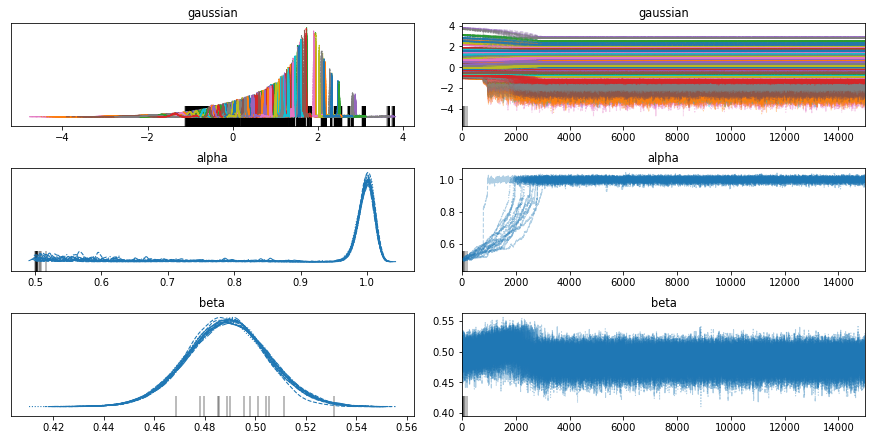

In [8]:
# Plot the traces
pm.traceplot(trace)

In [17]:
rhat=az.rhat(trace)
rhat

<xarray.Dataset>
Dimensions:         (gaussian_dim_0: 400)
Coordinates:
  * gaussian_dim_0  (gaussian_dim_0) int64 0 1 2 3 4 5 ... 395 396 397 398 399
Data variables:
    gaussian        (gaussian_dim_0) float64 1.044 1.048 1.048 ... 1.047 1.047
    alpha           float64 1.049
    beta            float64 1.018

In [41]:
# Compute the mean solutions, after an (arbitrary) burnin

gaussian_samples = trace.get_values('gaussian',burn=ntune)
alpha_samples = trace.get_values('alpha',burn=ntune)
beta_samples  = trace.get_values('beta',burn=ntune)
lognormal_samples = np.array([LN.G_to_LN(gaussian_samples[n], alpha_samples[n]).reshape(Lside,Lside) for n in range(len(alpha_samples))])

mean_gaussian = gaussian_samples.mean(axis=0)
mean_alpha    = alpha_samples.mean()
mean_beta     = beta_samples.mean()
mean_lognormal = lognormal_samples.mean(axis=0)

da_samples = np.stack([alpha_samples,beta_samples],axis=-1)
da_weights = np.ones((da_samples.shape[0]))
np.savez(dataout+'_da_'+str(f),samples=da_samples,weights=da_weights)

data=lognormfields[f]['field']
posterior_mean=mean_lognormal
difference=data-posterior_mean
rhat_field=np.array(rhat['gaussian']).reshape(Lside,Lside)
np.savez(dataout+'_da_fields_'+str(f),data=data,posterior_mean=posterior_mean,difference=difference,rhat_field=rhat_field)

print('Mean alpha, beta:',mean_alpha,mean_beta)
print('True alpha, beta:',alpha,beta)
print('Gelman-Rubin rhat alpha, beta:',float(rhat['alpha']),float(rhat['beta']))

Mean alpha, beta: 0.9986622969568772 0.4861925596461595
True alpha, beta: 1.0 0.5
Gelman-Rubin rhat alpha, beta: 1.048958196171163 1.018065510405625


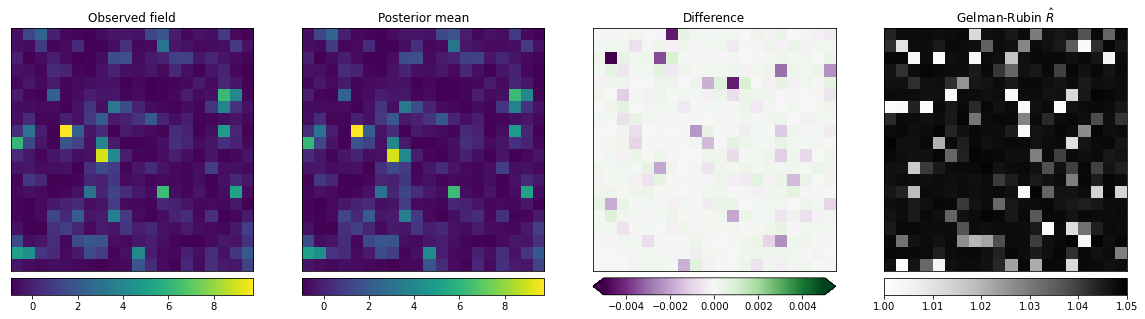

In [51]:
fig=plt.figure(figsize=(20,6))
ax0=fig.add_subplot(1,4,1)
ax0.set_xticks([])
ax0.set_yticks([])
im0 = ax0.imshow(data, cmap='viridis', vmin=np.min((data.min(),posterior_mean.min())), vmax=np.max((data.max(),posterior_mean.max())))
ax0.set_title("Observed field")
ax0_divider = make_axes_locatable(ax0)
cax0 = ax0_divider.append_axes("bottom", size="7%", pad=0.1)
cb0 = fig.colorbar(im0, cax=cax0, orientation="horizontal")

ax1=fig.add_subplot(1,4,2)
ax1.set_xticks([])
ax1.set_yticks([])
im1 = ax1.imshow(posterior_mean, cmap='viridis', vmin=np.min((data.min(),posterior_mean.min())), vmax=np.max((data.max(),posterior_mean.max())))
ax1.set_title("Posterior mean")
ax1_divider = make_axes_locatable(ax1)
cax1 = ax1_divider.append_axes("bottom", size="7%", pad=0.1)
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal")

ax2=fig.add_subplot(1,4,3)
ax2.set_xticks([])
ax2.set_yticks([])
im2 = ax2.imshow(difference, cmap='PRGn', vmin=-0.005, vmax=0.005)
ax2.set_title("Difference")
ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("bottom", size="7%", pad=0.1)
cb2 = fig.colorbar(im2, cax=cax2, orientation="horizontal", extend='both')

ax3=fig.add_subplot(1,4,4)
ax3.set_xticks([])
ax3.set_yticks([])
im3 = ax3.imshow(rhat_field, cmap='Greys', vmin=1., vmax=1.05)
ax3.set_title("Gelman-Rubin $\\hat{R}$")
ax3_divider = make_axes_locatable(ax3)
cax3 = ax3_divider.append_axes("bottom", size="7%", pad=0.1)
cb3 = fig.colorbar(im3, cax=cax3, orientation="horizontal")

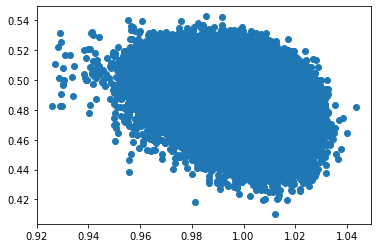

In [21]:
plt.scatter(alpha_samples,beta_samples)

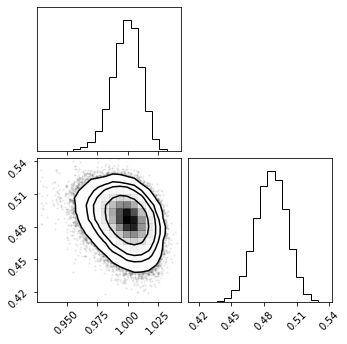

In [22]:
# Plot pymc3 samples as corner plot
samples = np.zeros((alpha_samples.size,2))
samples[:,0] = alpha_samples
samples[:,1] = beta_samples
figure = corner.corner(samples,levels=[0.68,0.9,0.955,0.99])
plt.savefig(fileout+'_corner.png')

In [23]:
alphas  = np.linspace(alphamin,alphamax,nalpha)
betas   = np.linspace(betamin,betamax,nbeta)
lnl     = np.zeros((nalpha,nbeta))
marg_beta  = np.sum(np.exp(lnl[:,:]),axis=0)
marg_alpha = np.sum(np.exp(lnl[:,:]),axis=1)

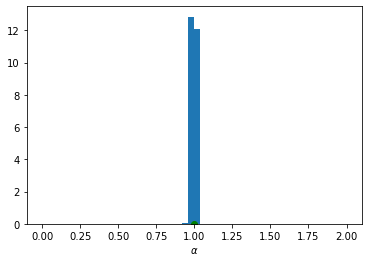

In [24]:
# Plot marginal distribution of alpha
# plt.plot(alphas,marg_alpha)
plt.hist(alpha_samples,bins=50,range=(alphamin,alphamax),density=True)
plt.xlabel('$\\alpha$')
plt.plot(alpha ,0,'go')

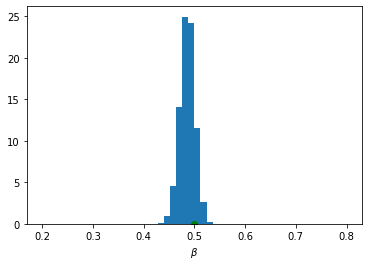

In [25]:
# Plot marginal distributions of beta
# plt.plot(betas,marg_beta)
plt.hist(beta_samples,bins=50,range=(betamin,betamax),density=True)
plt.xlabel('$\\beta$')
plt.plot(beta ,0,'go')

# Kernel density estimate

In [6]:
alphamin, alphamax = 0., 2.
betamin, betamax = 0.2, 0.8
nalpha = 500
nbeta = 500
alphas=np.linspace(alphamin,alphamax,nalpha)
betas=np.linspace(betamin,betamax,nbeta)

def get_kde_values(alpha_samples,beta_samples):
    from scipy.stats import gaussian_kde
    values = np.vstack([alpha_samples, beta_samples])
    kernel = gaussian_kde(values)

    A, B = np.mgrid[alphamin:alphamax:nalpha*1j, betamin:betamax:nbeta*1j]
    positions = np.vstack([A.ravel(), B.ravel()])
    Z = np.reshape(kernel(positions).T, A.shape).T
    Z = np.log(Z)
    Z -= np.max(Z)
    return Z

alpha_samples = {}
beta_samples = {}
kde = {}
fields = range(4)
for f in fields:
    print("field "+str(f))
    A = np.load(dataout+'_da_'+str(f)+'.npz')
    alpha_samples[f], beta_samples[f] = A['samples'].T[0], A['samples'].T[1]

    kde[f] = get_kde_values(alpha_samples[f], beta_samples[f])

lnL = np.zeros((nalpha,nbeta))
lnL = np.sum([kde[f] for f in fields],axis=0)
lnL -= lnL.max()

field 0
field 1
field 2
field 3


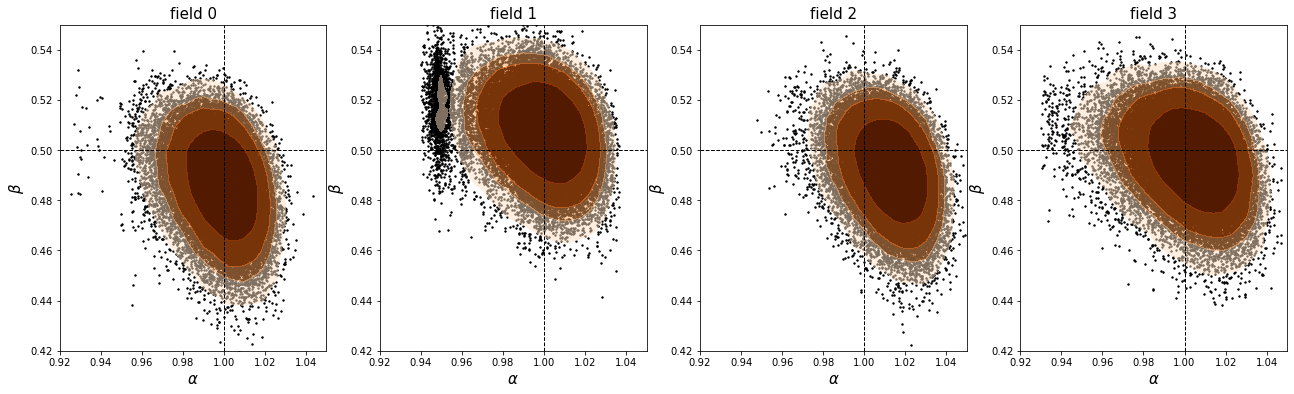

In [13]:
N=50000
alphamin, alphamax = 0.92, 1.05
betamin, betamax = 0.42, 0.55

fig=plt.figure(figsize=(22,6))
ax0=fig.add_subplot(1,4,1)
ax0.set_xlabel("$\\alpha$",fontsize=15)
ax0.set_ylabel("$\\beta$",fontsize=15)
ax0.set_title("field 0",fontsize=15)
ax0.set_xlim([alphamin,alphamax])
ax0.set_ylim([betamin,betamax])
ax0.axvline(alpha,lw=1,ls="--",color="k")
ax0.axhline(beta,lw=1,ls="--",color="k")
im0 = ax0.scatter(alpha_samples[0][:N], beta_samples[0][:N], s=2., color='k')
ax0.contourf(alphas,betas,kde[0],contour_levels,cmap="Oranges",alpha=0.5)

ax1=fig.add_subplot(1,4,2)
ax1.set_xlabel("$\\alpha$",fontsize=15)
ax1.set_ylabel("$\\beta$",fontsize=15)
ax1.set_title("field 1",fontsize=15)
ax1.set_xlim([alphamin,alphamax])
ax1.set_ylim([betamin,betamax])
ax1.axvline(alpha,lw=1,ls="--",color="k")
ax1.axhline(beta,lw=1,ls="--",color="k")
im1 = ax1.scatter(alpha_samples[1][:N], beta_samples[1][:N], s=2., color='k')
ax1.contourf(alphas,betas,kde[1],contour_levels,cmap="Oranges",alpha=0.5)

ax2=fig.add_subplot(1,4,3)
ax2.set_xlabel("$\\alpha$",fontsize=15)
ax2.set_ylabel("$\\beta$",fontsize=15)
ax2.set_title("field 2",fontsize=15)
ax2.set_xlim([alphamin,alphamax])
ax2.set_ylim([betamin,betamax])
ax2.axvline(alpha,lw=1,ls="--",color="k")
ax2.axhline(beta,lw=1,ls="--",color="k")
im2 = ax2.scatter(alpha_samples[2][:N], beta_samples[2][:N], s=2., color='k')
ax2.contourf(alphas,betas,kde[2],contour_levels,cmap="Oranges",alpha=0.5)

ax3=fig.add_subplot(1,4,4)
ax3.set_xlabel("$\\alpha$",fontsize=15)
ax3.set_ylabel("$\\beta$",fontsize=15)
ax3.set_title("field 3",fontsize=15)
ax3.set_xlim([alphamin,alphamax])
ax3.set_ylim([betamin,betamax])
ax3.axvline(alpha,lw=1,ls="--",color="k")
ax3.axhline(beta,lw=1,ls="--",color="k")
im3 = ax3.scatter(alpha_samples[3][:N], beta_samples[3][:N], s=2., color='k')
ax3.contourf(alphas,betas,kde[3],contour_levels,cmap="Oranges",alpha=0.5)

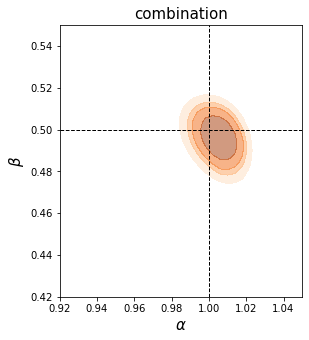

In [10]:
fig=plt.figure(figsize=(20,5))
ax0=fig.add_subplot(1,4,1)
ax0.set_xlabel("$\\alpha$",fontsize=15)
ax0.set_ylabel("$\\beta$",fontsize=15)
ax0.set_title("combination",fontsize=15)
ax0.set_xlim([alphamin,alphamax])
ax0.set_ylim([betamin,betamax])
ax0.axvline(alpha,lw=1,ls="--",color="k")
ax0.axhline(beta,lw=1,ls="--",color="k")
ax0.contourf(alphas,betas,lnL,contour_levels,cmap="Oranges",alpha=0.5)

In [12]:
np.savez(dataout+'_da_kde',alphas=alphas,betas=betas,lnL0=kde[0],lnL1=kde[1],lnL2=kde[2],lnL3=kde[3],lnL=lnL)